In [1]:
#!/usr/bin/env python
"""
Demo for Deblurring test problem on a large scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [2]:
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import astra
import trips.utilities.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.test_problems.Deblurring import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from scipy.linalg import qr

#### In this notebook we illustrate how to use the Deblurring class. The main features are:
1. Define a large scale Deblurring problem 
2. Use regularization methods and illustrate their performance

   - 2.1. Hybrid_GMRES 

   - 2.2. Hybrid_LSQR 

   - 2.3. GKS 
   
   - 2.4. MMGKS


#### 1. Define a large scale Deblurring test problem

In [20]:
# Create an object of class Deblurring()
Deblur = Deblurring(CommitCrime = False)
nx = 128
ny = 128
A = Deblur.forward_Op((9,9), (3,3), nx, ny)
choose_image = 'satellite'
# generate_matrix = False
x_true = Deblur.gen_true(choose_image)
b_true = Deblur.gen_data(x_true) # generate_matrix)
(b, delta) = Deblur.add_noise(b_true, opt= 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

data already in the path.


(-0.5, 127.5, 127.5, -0.5)

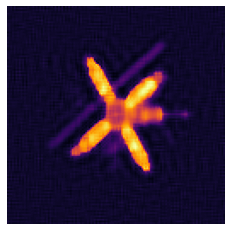

In [27]:
plt.imshow(x_mmgks.reshape((nx,ny)))
plt.set_cmap('inferno')
plt.axis('off')

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fd0fdf68be0>)

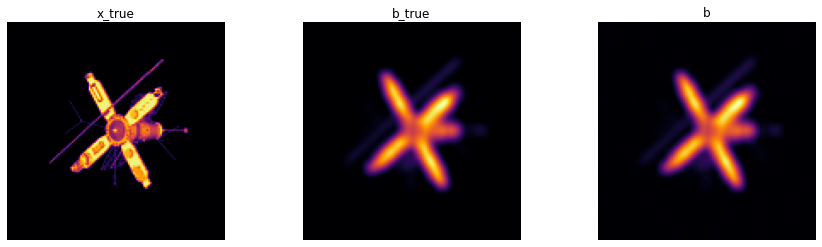

In [21]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Step 3: Solve the regularized problem with GKS and Hybrid_lsqr that solves

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator for GKS and $L = I$ for Hybrid_lsqr, for an computed value of the regularization parameter $\lambda$. 


In [5]:
b_vec = b.reshape((-1,1))
(x_hybrid_gmres, info_hybrid_gmres) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'gcv', x_true = x_true, delta = delta)

running Arnoldi algorithm...:   0%|          | 0/100 [00:00<?, ?it/s]

running Arnoldi algorithm...: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


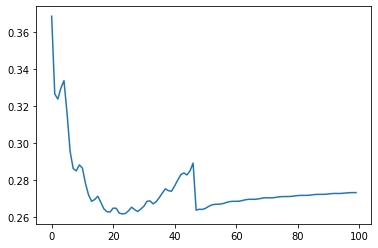

In [6]:
plt.plot(info_hybrid_gmres['relError'])

In [7]:
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 100, regparam = 'gcv', x_true = x_true, delta = delta)

running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


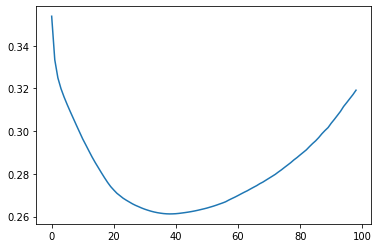

In [8]:
plt.plot(info_hybrid_lsqr['relError'])

(-0.5, 127.5, 127.5, -0.5)

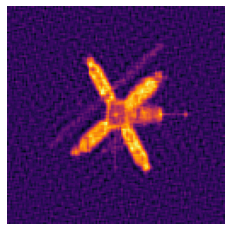

In [9]:
plt.imshow(x_hybrid_lsqr.reshape((nx, ny)))
plt.set_cmap('inferno')
plt.axis('off')

In [10]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


In [11]:
info_gks['relError']

[0.41455898156681054,
 0.3191541949988509,
 0.3136730968506477,
 0.31039412713604847,
 0.30709936465902143,
 0.30408520206102096,
 0.30111886044321945,
 0.29822147443025643,
 0.2958802950790608,
 0.2974121557453438,
 0.29859899044554145,
 0.30020059685814465,
 0.303316012403111,
 0.3066436129551794,
 0.30713325230199884,
 0.3052257553975557,
 0.30071823080338667,
 0.2950051342037431,
 0.2977071435144601,
 0.2968962074609047,
 0.2969420975529856,
 0.29751645612634775,
 0.2966087554423311,
 0.29795486019834394,
 0.2966904500201305,
 0.29818263965628294,
 0.29707725066368523,
 0.29730943762331613,
 0.297998773991476,
 0.29801173348490717,
 0.29781852434264605,
 0.2979462442604,
 0.29807026511981916,
 0.297839330156286,
 0.29758828866134335,
 0.297301998091478,
 0.29680584997579873,
 0.296150829737003,
 0.29683546464638416,
 0.29644733899705683,
 0.2959817603454182,
 0.29718376316804734,
 0.2983603928296273,
 0.30056013591001934,
 0.30234102610448976,
 0.3036595165539835,
 0.30457450526925

Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [12]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=0.1, projection_dim=3, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running MMGKS...: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


In [13]:
info_mmgks['relError']

[0.3616916908667813,
 0.32450366655677193,
 0.31929344726932907,
 0.3152932162381646,
 0.31173077390858117,
 0.3083823473687269,
 0.3051571704052661,
 0.30192704866525377,
 0.29877282005990885,
 0.2976061787343475,
 0.2975827711276184,
 0.29788157911273244,
 0.29796468798727216,
 0.2977270377440606,
 0.29723089795168606,
 0.296507043596323,
 0.2956778575597953,
 0.2948610248400603,
 0.2941023091658835,
 0.2933503213256622,
 0.29245576782753574,
 0.2914818699904127,
 0.29023095338959004,
 0.28886067201526355,
 0.2873402705114956,
 0.2856342955604673,
 0.28391043223927115,
 0.28215548803727897,
 0.28025908875466704,
 0.2784654332344941,
 0.27681818398174735,
 0.2751907943780772,
 0.2735443223369542,
 0.27199379391990297,
 0.27051400695460487,
 0.2690773113922533,
 0.26772553037146357,
 0.26640655390073203,
 0.26518968498026674,
 0.2639365417460962,
 0.2626290876972343,
 0.2613852822093681,
 0.2602324709285228,
 0.2591266711082825,
 0.2579296949713982,
 0.25674979949421894,
 0.25557456246

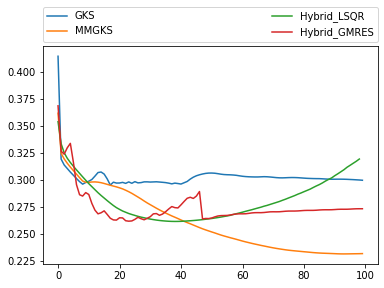

In [14]:
plot_gks = plt.plot(info_gks['relError'], label='GKS')
plot_mmgks = plt.plot(info_mmgks['relError'], label='MMGKS')
plot_hybrid_lsqr = plt.plot(info_hybrid_lsqr['relError'], label='Hybrid_LSQR')
plot_hybrid_gmres = plt.plot(info_hybrid_gmres['relError'], label = 'Hybrid_GMRES')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

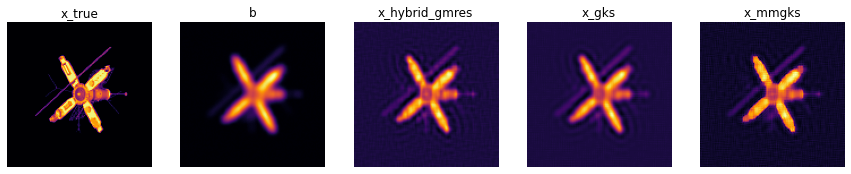

In [15]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,5,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,5,2), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))
plt.subplot(1,5,3), plt.title('x_hybrid_gmres'), plt.axis('off'), plt.imshow(x_hybrid_gmres.reshape((nx,ny)))
plt.subplot(1,5,4), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx,ny)))
plt.subplot(1,5,5), plt.title('x_mmgks'), plt.axis('off'), plt.imshow(x_mmgks.reshape((nx,ny)))
plt.set_cmap('inferno')
plt.axis('off')